In [2]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [3]:
provider = IBMQ.load_account()

In [4]:
def rand_numb(low_in,high_in):
    '''
    Returns a random number between low_in and high_in, including both end points.
    '''
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

In [5]:
'''
Define variables for the number of layers and qubits of the prover. Define global variables used in the optimization.
'''
numLayer = 3
numQubit = 3
global iterations
global noisy

In [6]:
def createProver(numQubit, numLayer):
    '''
    Creates a parameterized unitary on numQubit qubits. Applies numLayer layers of the HEA with 2 Qiskit.parameters 
    per qubit per layer, specifying rotations about the x- and y-axes. After each layer, applies a neighbouring qubit
    CNOT layer. Returns a QuantumCircuit object containing the parameterized prover. 
    '''
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

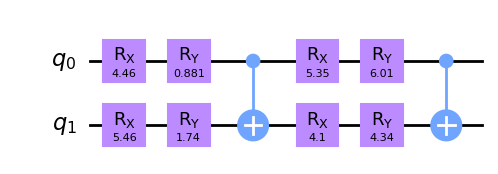

In [7]:
'''
Defines parameters that specify the purification of state to be tested. Create a QuantumCircuit object that
creates the purification on (size) number of qubits.
'''
unitary_param_1 = np.array([])
size = 2
layers = 2
for i in range(0, 2*size*layers):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [8]:
def createEqSuperposDihedralSE():
    '''
    Defines a quantum circuit to create the uniform superposition of basis elements required.
    '''
    temp = QuantumCircuit(3)
    temp.ry(2*np.arctan(1/np.sqrt(2)), 0)
    temp.x(0)
    temp.ch(0, 1)
    temp.x(0)
    temp.h(2)
    return temp

In [16]:
def createQuantumCircuit(state, numQubit, numLayer):
    '''
    Creates quantum circuit for the problem. 
    Refer to Section 3.D from https://arxiv.org/pdf/2105.12758
    The ciruit contains 7 qubits each labelled as (C, S, S', E)
    '''
    circ = QuantumCircuit(7)
    
    superPosCircuit = createEqSuperposDihedralSE()
    circ.append(superPosCircuit, [0, 1, 2])

    circ.append(state, [3, 4])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [4, 5, 6])
    
    circ.ccx(2, 4, 3)
    circ.ccx(2, 6, 5)
    
    circ.cswap(1, 3, 4)
    circ.cswap(1, 5, 6)
    
    circ.ccx(0, 3, 4)
    circ.ccx(0, 5, 6)
    
    circ.append(superPosCircuit.inverse(), [0, 1, 2])
    
    return circ

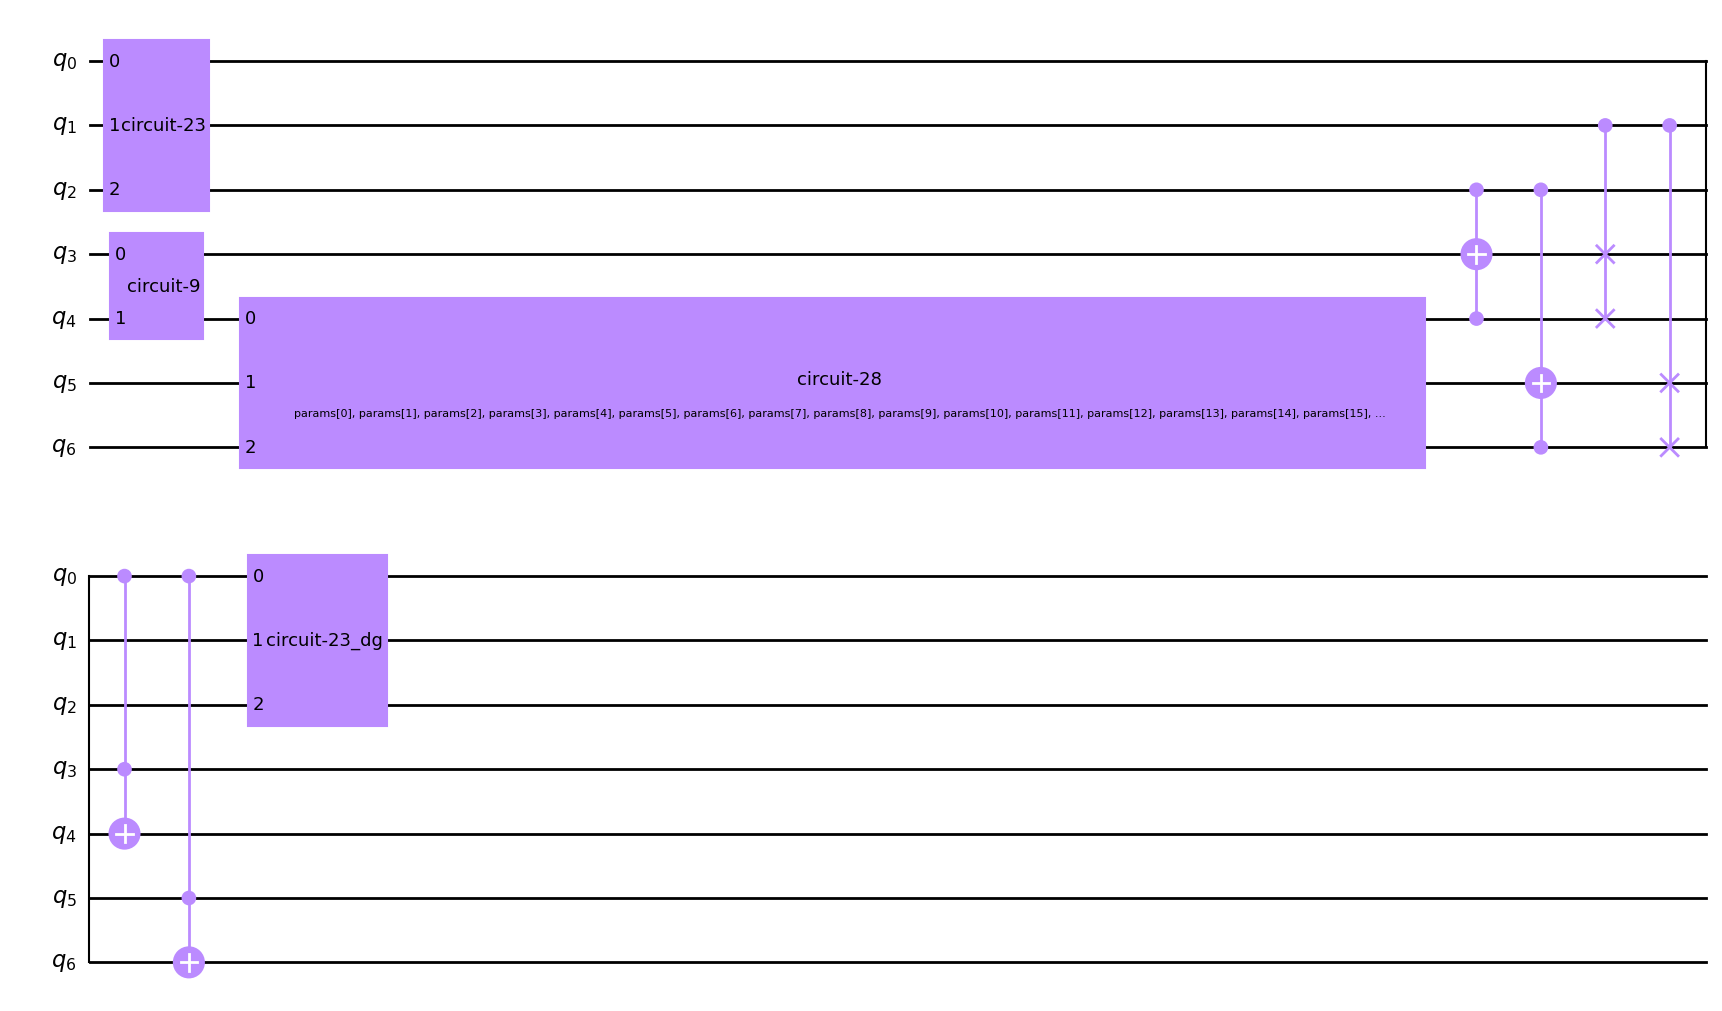

In [11]:
'''
Creates the quantum circuit
'''
qCirc = createQuantumCircuit(state, numQubit, numLayer)
qCirc.draw('mpl')

In [12]:
'''
List of parameters of the quantum circuit.
'''
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3]), ParameterVectorElement(params[4]), ParameterVectorElement(params[5]), ParameterVectorElement(params[6]), ParameterVectorElement(params[7]), ParameterVectorElement(params[8]), ParameterVectorElement(params[9]), ParameterVectorElement(params[10]), ParameterVectorElement(params[11]), ParameterVectorElement(params[12]), ParameterVectorElement(params[13]), ParameterVectorElement(params[14]), ParameterVectorElement(params[15]), ParameterVectorElement(params[16]), ParameterVectorElement(params[17])])


In [13]:
'''
Pick a backend to use. We use the statevector_simulator for noiseless simulation.
'''
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [14]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation.
'''
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [15]:
def costf(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the expectation value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [91]:
def gradient(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the gradient value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [93]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    '''
    Callback function called automatically during optimization. Appends loss value, current iteration and 
    prints every iteration with a completion percentage.
    '''
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [89]:
'''
Average value of this hamiltonian is the probability of measuring 0 on the first three qubits.
MatrixOp(np.array([[1, 0], [0, 0])) is the projector on the 0 subspace. Qiskit orders qubits in reverse.
'''
hamiltonian = I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [94]:
'''
Initialize prover parameters to random angles
'''
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[3.73057632 0.58960894 2.09227301 2.62298491 4.40429791 4.18817919
 3.13228705 5.29401757 3.03300481 0.63449167 0.8429973  2.38376382
 1.7968865  0.46950842 3.32830389 4.88074699 4.65965078 1.66487549]
Initial Cost :  0.301081257637862


In [95]:
'''
True value calculated using the SDP.
'''
true_value = 0.9714039912587995

In [96]:
'''
Perform the noiseless optimization using the SPSA algorithm for 200 iterations.
'''
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.301081257637862
Loss Value :  0.1658273340716512 1.0%
Loss Value :  0.23007830487502656 2.0%
Loss Value :  0.26878584755240953 3.0%
Loss Value :  0.31401099775809427 4.0%
Loss Value :  0.3440520459045439 5.0%
Loss Value :  0.34146561961114374 6.0%
Loss Value :  0.37688265565981316 7.0%
Loss Value :  0.3770635886748124 8.0%
Loss Value :  0.5156284780738895 9.0%
Loss Value :  0.5861383995093562 10.0%
Loss Value :  0.5642019672945937 11.0%
Loss Value :  0.4191209154621808 12.0%
Loss Value :  0.49517265860674065 13.0%
Loss Value :  0.4551788904002328 14.0%
Loss Value :  0.48376458186409227 15.0%
Loss Value :  0.49626138666359787 16.0%
Loss Value :  0.540249446659917 17.0%
Loss Value :  0.5602274369126599 18.0%
Loss Value :  0.561747374065707 19.0%
Loss Value :  0.5931897836672031 20.0%
Loss Value :  0.5763144487735055 21.0%
Loss Value :  0.6218819322619235 22.0%
Loss Value :  0.6211946469633652 23.0%
Loss Value :  0.6165975652177927 24.0%
Loss Value :  0.6184510272585761 

In [97]:
'''
Perform the noisy optimization using the SPSA algorithm for 200 iterations.
'''
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.2468435061482415
Loss Value :  0.21069185262506793 1.0%
Loss Value :  0.3449488771163504 2.0%
Loss Value :  0.3587883971907447 3.0%
Loss Value :  0.3831091108154611 4.0%
Loss Value :  0.37986597171722164 5.0%
Loss Value :  0.4416450616451567 6.0%
Loss Value :  0.43097038207464283 7.0%
Loss Value :  0.4379387787191797 8.0%
Loss Value :  0.45487579466893346 9.0%
Loss Value :  0.44172535352265846 10.0%
Loss Value :  0.48792925020667094 11.0%
Loss Value :  0.3410668351891243 12.0%
Loss Value :  0.3552135243818964 13.0%
Loss Value :  0.346449283528674 14.0%
Loss Value :  0.3796655788749162 15.0%
Loss Value :  0.3972639535533056 16.0%
Loss Value :  0.37061852490217395 17.0%
Loss Value :  0.385095621828844 18.0%
Loss Value :  0.4210441477509925 19.0%
Loss Value :  0.4234925487289304 20.0%
Loss Value :  0.43455095402796595 21.0%
Loss Value :  0.46735687386788594 22.0%
Loss Value :  0.43050726850200577 23.0%
Loss Value :  0.46528970643978385 24.0%
Loss Value :  0.4335678873412

In [98]:
'''
Evaluate the noiseless cost function using the parameters learned from the noisy optimization. 
'''
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.9763548790527175


In [99]:
'''
Print all final values after training.
'''
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  0.9714039912587995
Noiseless :  0.9987670437398415
Noisy :  0.6900512295096578
Noise Resilient Value :  0.9763548790527175


In [47]:
def writeToFile():
    '''
    Write the training data to a text file to be used to plot the data. The format is as follows:
        True Value
        Noise Resilient Value
        Size of noiseless data list
        [
        Noiseless data with one entry per line
        ]
        Size of noisy data list
        [
        Noisy data with one entry per line
        ]
    '''
    file = open("Dihedral_GSE.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [48]:
writeToFile()